In [1]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import gamma

%matplotlib widget

In [30]:
# Enable implicit multi-threading (optional)
ROOT.ROOT.EnableImplicitMT()

# Open the ROOT file
file = ROOT.TFile.Open("./data/hole_2mm.root")
if not file or file.IsZombie():
    print("Error opening file.")
    exit()

# Get the TTree
tree = file.Get("events")
if not tree:
    print("Tree not found.")
    exit()

# Set up the branch name you want to extract
branch_name = "gain"

# Use RDataFrame for convenience
df = ROOT.RDataFrame(tree)

# Convert the branch to a NumPy array
array = np.array(df.AsNumpy([branch_name])[branch_name])

tree = file.Get("electrons")
df = ROOT.RDataFrame(tree)
xfs  = np.array(df.AsNumpy(['xf'])['xf']) * 10
yfs  = np.array(df.AsNumpy(['yf'])['yf']) * 10


In [31]:
# Set the number of bins (e.g., 100) or define custom bin edges
num_bins = 20
counts, bin_edges = np.histogram(array, bins=num_bins)

# Calculate bin centers from edges
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# X = bin centers, Y = counts
err = np.sqrt(counts +1)
X = bin_centers
Y = counts

Chi-squared = 43.80
Reduced chi-squared = 2.58


/var/folders/p4/z5pfwnjs7x7d9zcwks7kn0j80000gn/T/ipykernel_13065/3278843214.py:4: RuntimeWarning: invalid value encountered in scalar power
  return norm * (beta**(1 + theta)) / gamma(1 + theta) * x**theta * np.exp(-beta * x)


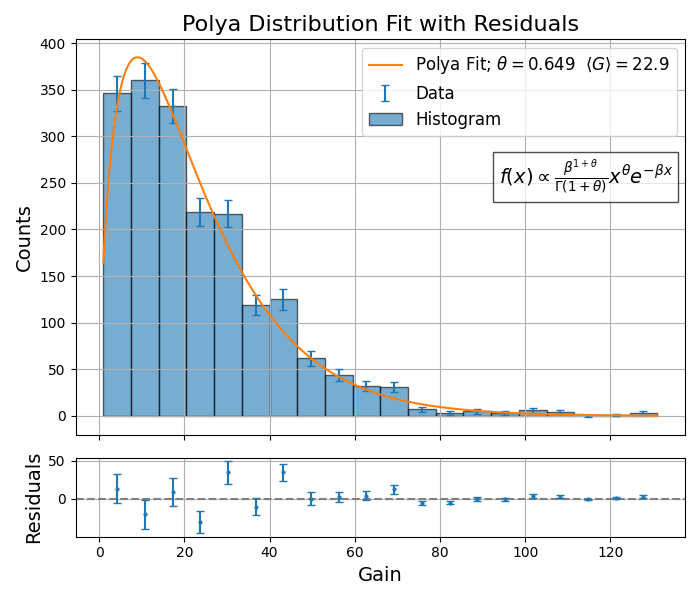

In [44]:
# Define Polya (Gamma) PDF shape function for fitting
def polya_pdf(x, theta, mean_gain, norm):
    beta = (1 + theta) / mean_gain
    return norm * (beta**(1 + theta)) / gamma(1 + theta) * x**theta * np.exp(-beta * x)

# Initial parameter guesses: theta, mean, normalization
p0 = [1.0, np.mean(array), np.max(Y)]
# Fit
params, cov = curve_fit(polya_pdf, bin_centers, counts, p0=p0, sigma=err, absolute_sigma=True)
fit_vals = polya_pdf(bin_centers, *params)
residuals = (counts - fit_vals) 
theta_fit, mean_fit, norm_fit = params
# Create a 2-panel plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 6), sharex=True, gridspec_kw={'height_ratios': [5, 1]})

# Plot histogram and fit
ax1.errorbar(bin_centers, counts, yerr=err, fmt='o', label="Data", markersize=0, capsize=3)
x_fit = np.linspace(min(array), max(array), 500)
ax1.plot(x_fit, polya_pdf(x_fit, *params), label=f"Polya Fit; $\\theta = {theta_fit:.3}$  $\\langle G \\rangle = {mean_fit:.3}$")

ax1.bar(bin_centers, counts, width=bin_edges[1] - bin_edges[0], alpha=0.6, label="Histogram", edgecolor='black')

ax1.set_ylabel("Counts", fontsize=14)
ax1.set_title("Polya Distribution Fit with Residuals", fontsize=16)
ax1.legend(fontsize=12)
ax1.grid(True)

# Plot residuals
ax2.axhline(0, color='gray', linestyle='--')
ax2.errorbar(bin_centers, residuals, yerr=err, fmt='o', markersize=2, capsize=3)
ax2.set_xlabel("Gain", fontsize=14)
ax2.set_ylabel("Residuals", fontsize=14)
ax2.grid(True)

residuals = counts - fit_vals
chi_squared = np.sum((residuals / err) ** 2)
ndf = len(counts) - len(params)  # number of degrees of freedom
reduced_chi_squared = chi_squared / ndf

print(f"Chi-squared = {chi_squared:.2f}")
print(f"Reduced chi-squared = {reduced_chi_squared:.2f}")

# Add Polya equation as a label on the plot
polya_eq = r"$f(x) \propto \frac{\beta^{1+\theta}}{\Gamma(1+\theta)} x^{\theta} e^{-\beta x}$"
ax1.text(0.98, 0.70, polya_eq, transform=ax1.transAxes, fontsize=14,
         verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.7))

plt.tight_layout()
plt.show()

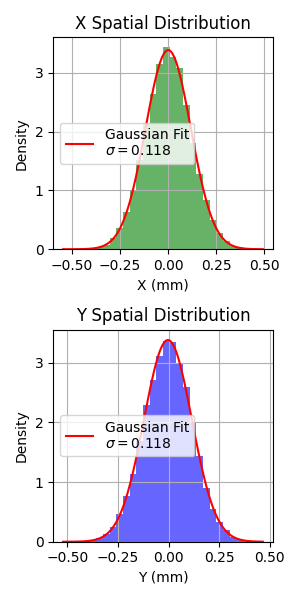

In [70]:
from scipy.stats import norm

# Fit Gaussian to xfs
xfs_mean, xfs_std = norm.fit(xfs)
xfs_fit = np.linspace(min(xfs), max(xfs), 100)
xfs_pdf = norm.pdf(xfs_fit, xfs_mean, xfs_std)

# Fit Gaussian to yfs
yfs_mean, yfs_std = norm.fit(yfs)
yfs_fit = np.linspace(min(yfs), max(yfs), 100)
yfs_pdf = norm.pdf(yfs_fit, yfs_mean, yfs_std)

# Create a figure with two vertically stacked subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(3, 6), sharex=False)

# Histogram of xfs with Gaussian fit
ax1.hist(xfs, bins=30, density=True, alpha=0.6, color='g')
ax1.plot(xfs_fit, xfs_pdf, 'r-', label=f"Gaussian Fit\n$\\sigma={xfs_std:.3f}$")
ax1.set_title("X Spatial Distribution")
ax1.set_xlabel("X (mm)")
ax1.set_ylabel("Density")
ax1.legend()
ax1.grid(True)

# Histogram of yfs with Gaussian fit
ax2.hist(yfs, bins=30, density=True, alpha=0.6, color='b')
ax2.plot(yfs_fit, yfs_pdf, 'r-', label=f"Gaussian Fit\n$\\sigma={yfs_std:.3f}$")
ax2.set_title("Y Spatial Distribution")
ax2.set_xlabel("Y (mm)")
ax2.set_ylabel("Density")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


/var/folders/p4/z5pfwnjs7x7d9zcwks7kn0j80000gn/T/ipykernel_13065/2203409660.py:11: RuntimeWarning: invalid value encountered in scalar power
  return norm * (beta**(1 + theta)) / gamma(1 + theta) * x**theta * np.exp(-beta * x)
/var/folders/p4/z5pfwnjs7x7d9zcwks7kn0j80000gn/T/ipykernel_13065/2203409660.py:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


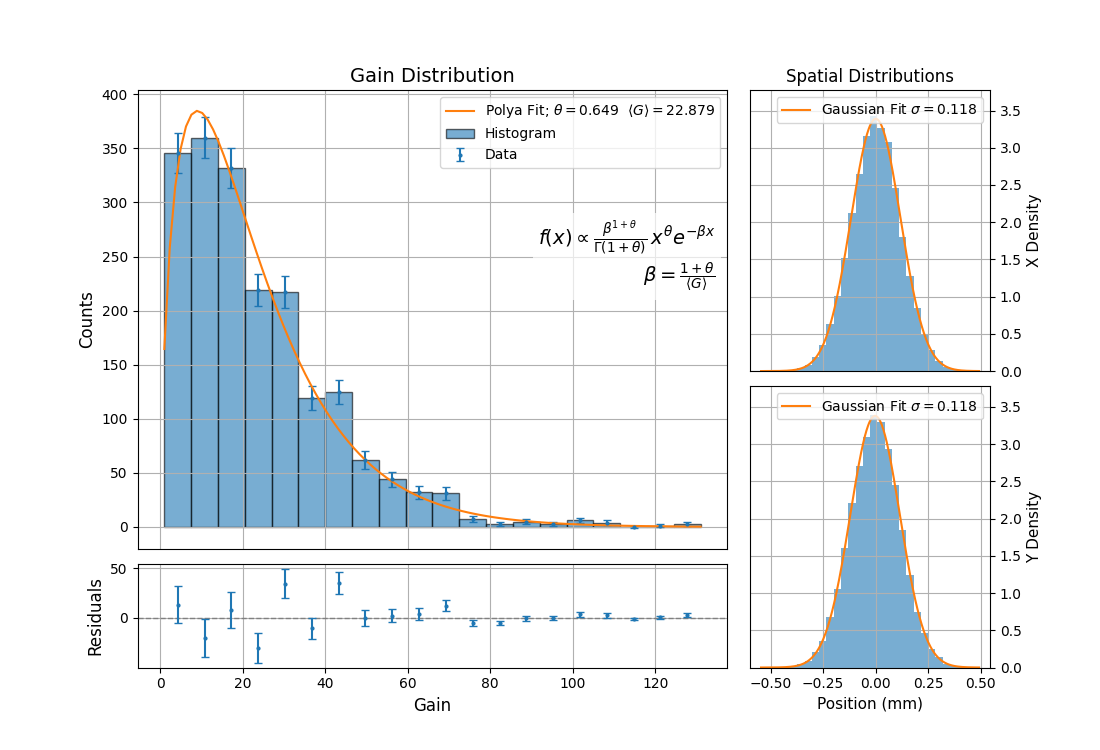

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.optimize import curve_fit
from scipy.special import gamma
from scipy.stats import norm

# --- Polya PDF ---
def polya_pdf(x, theta, mean_gain, norm):
    beta = (1 + theta) / mean_gain
    return norm * (beta**(1 + theta)) / gamma(1 + theta) * x**theta * np.exp(-beta * x)

# --- Fit Polya ---
p0 = [1.0, np.mean(array), np.max(counts)]
params, cov = curve_fit(polya_pdf, bin_centers, counts, p0=p0, sigma=err, absolute_sigma=True)
theta_fit, mean_fit, norm_fit = params
fit_vals = polya_pdf(bin_centers, *params)
residuals = counts - fit_vals

# --- Gaussian fits ---
xfs_mean, xfs_std = norm.fit(xfs)
yfs_mean, yfs_std = norm.fit(yfs)

# Shared x/y range for both Gaussian plots
gauss_min = min(np.min(xfs), np.min(yfs))
gauss_max = max(np.max(xfs), np.max(yfs))
gauss_fit_x = np.linspace(gauss_min, gauss_max, 400)
xfs_pdf = norm.pdf(gauss_fit_x, xfs_mean, xfs_std)
yfs_pdf = norm.pdf(gauss_fit_x, yfs_mean, yfs_std)

# Shared y-limit for both histograms
max_density = max(
    np.max(np.histogram(xfs, bins=30, range=(gauss_min, gauss_max), density=True)[0]),
    np.max(np.histogram(yfs, bins=30, range=(gauss_min, gauss_max), density=True)[0])
) * 1.1

# --- Figure layout ---
fig = plt.figure(figsize=(11, 7.5))
gs = GridSpec(10, 10, figure=fig, wspace=0.35, hspace=0.35)

# Polya + residuals (shared x-axis)
ax_polya = fig.add_subplot(gs[0:8, 0:7])
ax_res = fig.add_subplot(gs[8:10, 0:7], sharex=ax_polya)

# Gaussians with shared axes
ax_x = fig.add_subplot(gs[0:5, 7:10])
ax_y = fig.add_subplot(gs[5:10, 7:10], sharex=ax_x, sharey=ax_x)

# --- Polya main plot ---
ax_polya.bar(bin_centers, counts, width=bin_edges[1] - bin_edges[0],
             alpha=0.6, label="Histogram", edgecolor='black')
ax_polya.errorbar(bin_centers, counts, yerr=err, fmt='o', markersize=2, capsize=3, label="Data")
x_fit = np.linspace(np.min(array), np.max(array), 100)
ax_polya.plot(x_fit, polya_pdf(x_fit, *params),
              label=fr"Polya Fit; $\theta={theta_fit:.3f}$  $\langle G\rangle={mean_fit:.3f}$")
ax_polya.set_ylabel("Counts", fontsize=12)
ax_polya.set_title("Gain Distribution", fontsize=14)
ax_polya.grid(True)
ax_polya.legend(fontsize=10, loc="best")
polya_eq = r"$f(x)\propto \frac{\beta^{1+\theta}}{\Gamma(1+\theta)}\,x^{\theta}e^{-\beta x}$"

beta = r"$\beta = \frac{1+\theta}{\langle G \rangle}$"
polya_eq = r"$f(x)\propto \frac{\beta^{1+\theta}}{\Gamma(1+\theta)}\,x^{\theta}e^{-\beta x}$" + "\n" + beta

ax_polya.text(0.98, 0.72, polya_eq, transform=ax_polya.transAxes, fontsize=14,
              va='top', ha='right', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
# Removed Chi²/ndf annotation
ax_polya.tick_params(axis="x", which="both", bottom=False, labelbottom=False)

# --- Residuals ---
ax_res.axhline(0, color='gray', linestyle='--', linewidth=1)
ax_res.errorbar(bin_centers, residuals, yerr=err, fmt='o', markersize=2, capsize=3)
ax_res.set_xlabel("Gain", fontsize=12)
ax_res.set_ylabel("Residuals", fontsize=12)
ax_res.grid(True)

# --- X Gaussian (top) ---
ax_x.hist(xfs, bins=30, range=(gauss_min, gauss_max), density=True, alpha=0.6)
ax_x.plot(gauss_fit_x, xfs_pdf, '-', label=fr"Gaussian Fit $\sigma={xfs_std:.3f}$")
ax_x.set_title("Spatial Distributions", fontsize=12)
ax_x.set_ylim(0, max_density)
ax_x.legend(fontsize=10, loc="best")
ax_x.grid(True)
ax_x.yaxis.set_label_position("right")
ax_x.yaxis.tick_right()
ax_x.set_ylabel("X Density", fontsize=11)
ax_x.tick_params(axis="x", which="both", bottom=False, labelbottom=False)

# --- Y Gaussian (bottom) ---
ax_y.hist(yfs, bins=30, range=(gauss_min, gauss_max), density=True, alpha=0.6)
ax_y.plot(gauss_fit_x, yfs_pdf, '-', label=fr"Gaussian Fit $\sigma={yfs_std:.3f}$")
# Removed title from bottom Gaussian
ax_y.set_xlabel("Position (mm)", fontsize=11)
ax_y.set_ylim(0, max_density)
ax_y.legend(fontsize=10, loc="best")
ax_y.grid(True)
ax_y.yaxis.set_label_position("right")
ax_y.yaxis.tick_right()
ax_y.set_ylabel("Y Density", fontsize=11)


plt.tight_layout()
plt.show()


In [86]:
np.histogram(xfs, bins=30, range=(gauss_min, gauss_max), density=True)

(array([1.29278390e-03, 6.46391949e-04, 1.93917585e-03, 5.17113560e-03,
        1.68061907e-02, 3.55515572e-02, 7.62742500e-02, 1.86807273e-01,
        3.55515572e-01, 6.30878543e-01, 1.00384670e+00, 1.51902108e+00,
        2.12662951e+00, 2.64826782e+00, 3.15245354e+00, 3.43234125e+00,
        3.26169378e+00, 3.08135042e+00, 2.45822858e+00, 1.79955519e+00,
        1.27662410e+00, 8.42895102e-01, 4.89965098e-01, 2.76655754e-01,
        1.32510350e-01, 5.88216674e-02, 3.03804216e-02, 4.52474365e-03,
        4.52474365e-03, 6.46391949e-04]),
 array([-0.54556726, -0.51097933, -0.47639139, -0.44180346, -0.40721553,
        -0.3726276 , -0.33803967, -0.30345174, -0.26886381, -0.23427588,
        -0.19968795, -0.16510002, -0.13051209, -0.09592416, -0.06133622,
        -0.02674829,  0.00783964,  0.04242757,  0.0770155 ,  0.11160343,
         0.14619136,  0.18077929,  0.21536722,  0.24995515,  0.28454308,
         0.31913101,  0.35371895,  0.38830688,  0.42289481,  0.45748274,
         0.49207

In [88]:
yfs_std, yfs_mean

(np.float64(0.11800821902886417), np.float64(-0.0029539003534653366))

Text(0.5, 1.0, 'Gain Histogram')

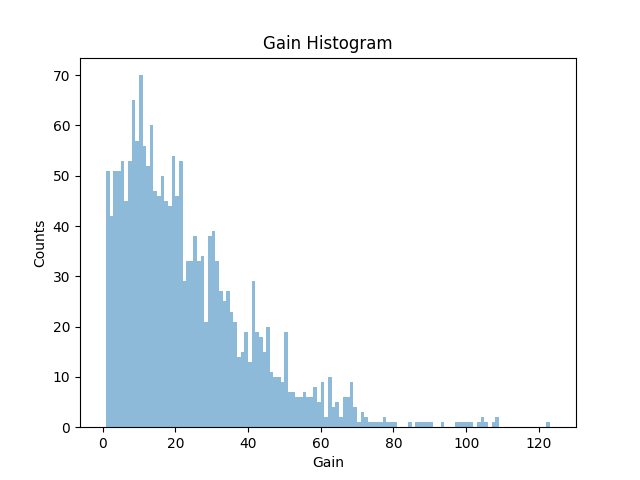

In [5]:
plt.figure()
plt.hist(array, bins=np.arange(0,125,1), alpha=0.5, label='HEED')
plt.xlabel("Gain")
plt.ylabel("Counts")
plt.title("Gain Histogram")


# Create Lookup Table from Fit

In [6]:

counts = polya_pdf(np.arange(120), *params)

pdf = counts / counts.sum() 
cdf = np.cumsum(pdf)

n = int(5e3)
table = np.zeros(n)
cdf *= n

for i in range(len(cdf)-1):
    table[int(cdf[i]):int(cdf[i+1])] = i+1
table[-1] = len(pdf-1)

In [7]:
print(f"int table[] = {{")
for i in range(0, len(table), 100):
    line = table[i:i+100]
    print("    " + ", ".join(f"{x:.10g}" for x in line) + ("," if i + 100 < len(table) else ""))
print("};")

int table[] = {
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
    2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
    3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
    4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

Text(0.5, 1.0, 'Garfield++ vs Lookup Table')

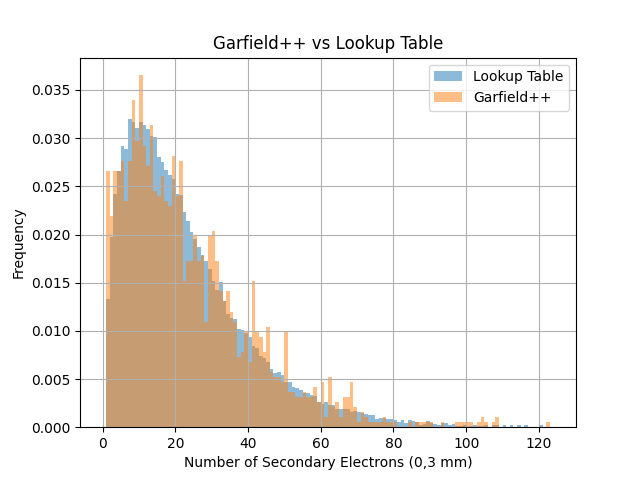

In [8]:
vals = []

for i in range(int(1e5)):
    vals.append(table[int(np.random.uniform(0, n))])

plt.figure()
plt.hist(vals, bins=np.arange(0, 125, 1), alpha=0.5, density=True,label='Lookup Table' )
plt.hist(array, bins=np.arange(0,125,1), alpha=0.5, density=True, label='Garfield++')
plt.legend()
plt.grid()
plt.xlabel('Number of Secondary Electrons (0,3 mm)')
plt.ylabel('Frequency')
plt.title('Garfield++ vs Lookup Table')

100 99


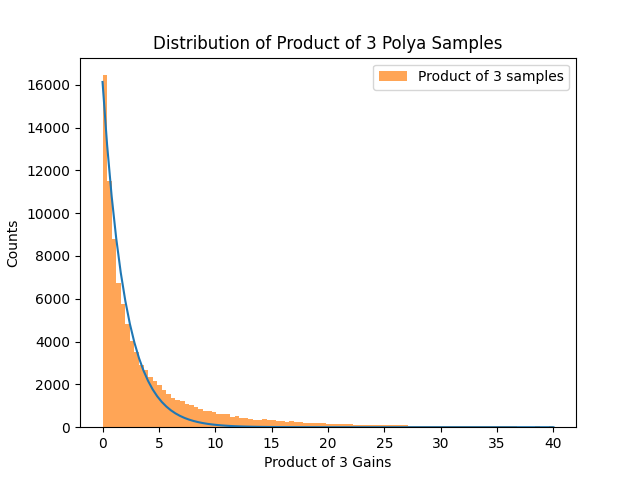

In [9]:
# Draw samples from the fitted Polya (Gamma) distribution
theta, mean_gain, norm = params
beta = (1 + theta) / mean_gain

# The Polya distribution is a Gamma distribution with shape=1+theta, scale=1/beta
shape = 1 + theta
scale = 1 / beta

# Number of samples to generate (same as original array)
n_samples = 100000

# Generate three independent samples for each event
samples1 = np.random.gamma(shape, scale, n_samples)
samples2 = np.random.gamma(shape, scale, n_samples)
samples3 = np.random.gamma(shape, scale, n_samples)

# Product of three samples
product_samples = samples1 * samples2 * samples3

product_samples /= 2400
counts, bins = np.histogram(product_samples, bins=np.linspace(0,40,100).astype('float64'))
bin_centers = 0.5 * (bins[1:] + bins[:-1])

def func(x, l, s):
    return l*np.exp(-x*l/s)

print(len(bins), len(counts))

popt, _ = curve_fit(func, bin_centers, counts)

plt.figure()
plt.plot(bins, func(bins, *popt))

# Plot the new distribution
plt.hist(product_samples, bins=np.linspace(0,40,100), alpha=0.7, label='Product of 3 samples')
plt.xlabel('Product of 3 Gains')
plt.ylabel('Counts')
plt.title('Distribution of Product of 3 Polya Samples')
plt.legend()
plt.show()

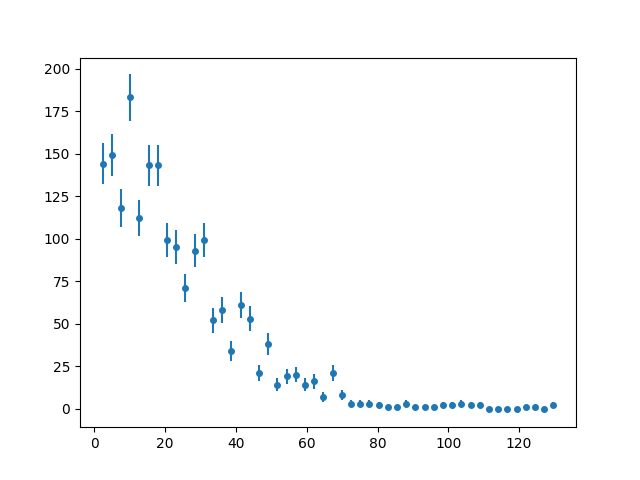

In [64]:
plt.figure()
plt.errorbar(X,Y, yerr=err, fmt='o', markersize=4)
plt.show()

[6.86821585e+03 1.00000000e+00 1.33079274e+06]


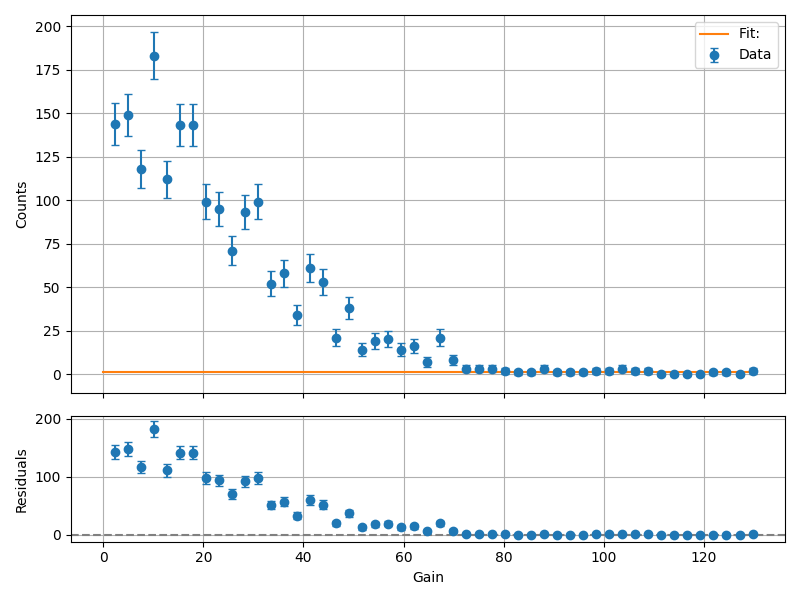

In [99]:
# Define the model function
def model(x, a, b, c):
    return a * np.power(x / c, b) + np.exp(-(1+b) * x / c)

# Fit the model (weighted fit using y-errors)
popt, pcov = curve_fit(model, X, Y, sigma=err, absolute_sigma=True, 
                       bounds=([0, 1, 0], [np.inf, np.inf, np.inf]),
                       p0 = [5000, 1.1, 14])
a_fit, b_fit, c_fit  = popt
a_err, b_err, c_fit = np.sqrt(np.diag(pcov))
print(popt)

# Fitted values and residuals
y_fit = model(X, a_fit, b_fit, c_fit)
residuals = Y - y_fit

# For smooth curve
x_smooth = np.linspace(0, max(X), 500)
y_smooth = model(x_smooth, a_fit, b_fit, c_fit)

# --- Plotting ---
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6), gridspec_kw={'height_ratios': [3, 1]})

# Top: Fit and data with error bars
ax1.errorbar(X, Y, yerr=err, fmt='o', label='Data', capsize=3)
ax1.plot(x_smooth, y_smooth, label=fr'Fit: ')
ax1.set_ylabel('Counts')
ax1.legend()
ax1.grid(True)

# Bottom: Residuals with error bars
ax2.axhline(0, color='gray', linestyle='--')
ax2.errorbar(X, residuals, yerr=err, fmt='o', capsize=3)
ax2.set_xlabel('Gain')
ax2.set_ylabel('Residuals')
ax2.grid(True)

plt.tight_layout()
plt.show()

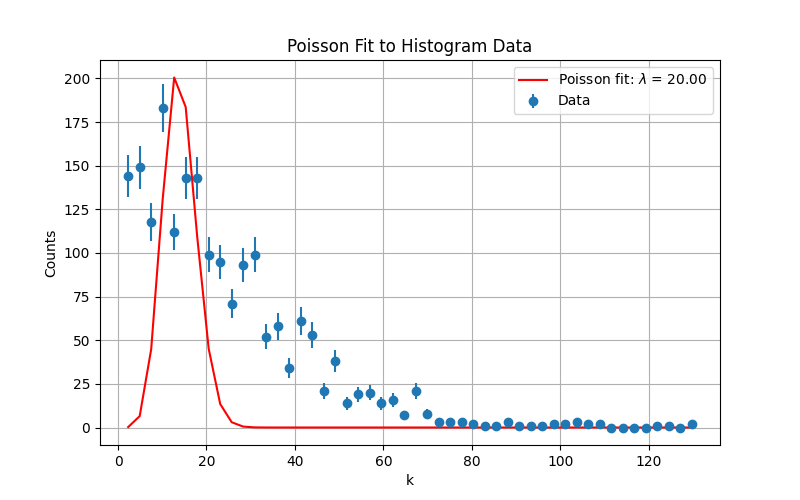

In [84]:
from scipy.special import factorial
from scipy.optimize import minimize

# Define Poisson model (not normalized to total counts)
def poisson_pmf(k, lam):
    return (lam**k * np.exp(-lam)) / factorial(k)

# Negative log-likelihood
def neg_log_likelihood(lam):
    if lam <= 0:
        return np.inf
    expected = poisson_pmf(X, lam) * np.sum(Y)  # scale to total
    return np.sum((expected - Y)**2 / (expected + 1e-9))  # chi-squared-style loss

# Minimize NLL to get best lambda
result = minimize(neg_log_likelihood, x0=[5], bounds=[(0.01, 20)])
lam_fit = result.x[0]

# Generate fit
y_fit = poisson_pmf(X, 14) * np.sum(Y)

# Plot
plt.figure(figsize=(8, 5))
plt.errorbar(X, Y, yerr=np.sqrt(Y), fmt='o', label='Data')
plt.plot(X, y_fit, 'r-', label=fr'Poisson fit: $\lambda$ = {lam_fit:.2f}')
plt.xlabel('k')
plt.ylabel('Counts')
plt.title('Poisson Fit to Histogram Data')
plt.legend()
plt.grid(True)
plt.show()

In [82]:
ROOT.gInterpreter.Declare('#include "TVector3.h"')
ROOT.ROOT.EnableImplicitMT()

# Open the ROOT file
file = ROOT.TFile.Open("./data/data.root")
if not file or file.IsZombie():
    print("Error opening file.")
    exit()

# Get the TTree
tree = file.Get("electrons")
if not tree:
    print("Tree not found.")
    exit()

# Set up the branch name you want to extract
branch_name = "path"

# Use RDataFrame for convenience
df = ROOT.RDataFrame(tree)

In [83]:

array = np.array(df.AsNumpy([branch_name]))

RuntimeError: The column named "path" is of type "ROOT::VecOps::RVec<TVector3>", which is not known to the ROOT interpreter. Please load the corresponding header files or dictionaries.

In [79]:
df.AsNumpy(['path'])

RuntimeError: The column named "path" is of type "ROOT::VecOps::RVec<TVector3>", which is not known to the ROOT interpreter. Please load the corresponding header files or dictionaries.